In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import decode_image
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.transforms import v2

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Currently using {device}")

Currently using cuda


In [3]:
train_dir_path = '/kaggle/input/cats-and-dogs-image-classification/train'
test_dir_path = '/kaggle/input/cats-and-dogs-image-classification/test'
classes = os.listdir(train_dir_path)

batch_size = 16
epoches = 50

In [4]:
transform = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [5]:
class_transform = {}
for cls in enumerate(classes):
    class_transform[cls[1]] = cls[0]

class_transform

{'dogs': 0, 'cats': 1}

In [6]:
def Get_paths_and_classes(dir_path):
    classes = os.listdir(dir_path)
    
    img_paths = []
    img_classes = []
    
    for cls in classes:
        class_img_dir_path = os.path.join(dir_path, cls)
        
        paths = [os.path.join(class_img_dir_path, img_name) for img_name in os.listdir(class_img_dir_path)]
        num_of_paths = len(paths)
        
        img_paths.extend(paths)
        img_classes.extend(num_of_paths*[cls])

    return img_paths, img_classes

In [7]:
train_img_paths, train_classes = Get_paths_and_classes(train_dir_path)
test_img_paths, test_classes = Get_paths_and_classes(test_dir_path)

In [8]:
class CustomDataset(Dataset):
    def __init__(self, img_paths, classes, img_transform = None, cls_transform = None):
        self.paths = img_paths
        self.classes = classes
        self.img_transform = img_transform
        self.cls_transform = cls_transform
    def __len__(self): 
        return len(self.classes)
    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = decode_image(img_path)
        if self.img_transform:
            img = transform(img)
            
        cls = self.classes[idx]
        if self.cls_transform:
            cls = self.cls_transform[cls]
            
        return img, cls

In [9]:
train_data = CustomDataset(train_img_paths, train_classes, transform, class_transform)
test_data = CustomDataset(test_img_paths, test_classes, transform, class_transform)

In [10]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [11]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16])


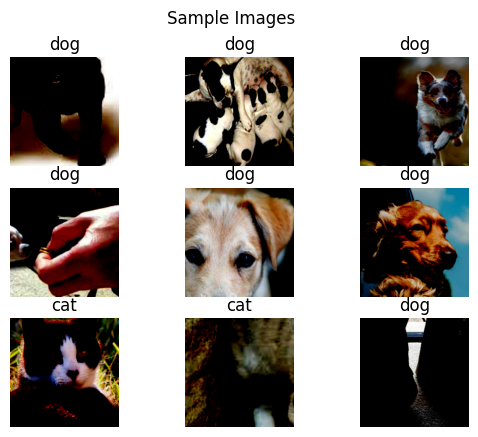

In [12]:
for idx in range(0,9):
    plt.subplot(3,3, idx+1)
    plt.imshow(train_features[idx].permute(1, 2, 0))
    plt.title('dog' if train_labels[idx] == 0 else 'cat')
    plt.axis('off')

plt.suptitle('Sample Images')
plt.show()

In [13]:
num_of_channels = train_data[0][0].shape[0]
num_of_classes = len(classes)

In [14]:
resnet_model = models.resnet18(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 81.1MB/s]


In [15]:
for param in resnet_model.parameters():
    param.requires_grad = False

resnet_model.fc.requires_grad = True

In [16]:
resnet_model.fc = nn.Sequential(
    nn.Linear(512, 128, bias = True),
    nn.Linear(128, 32, bias = True),
    nn.Linear(32, num_of_classes, bias = True),
)

resnet_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.fc.parameters(), lr=0.01)

In [18]:
num_of_batches = len(train_dataloader)
training_loss = []
training_accuracy = []

for epoch in range(epoches):
    batch_loss = 0
    batch_accuracy = 0
    for batch, (X, y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)

        logits = resnet_model(X)
        loss = loss_fn(logits, y)
        y_pred = torch.argmax(F.softmax(logits,dim = 1),dim = 1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss += loss.item()
        batch_accuracy += accuracy_score(y.cpu(),y_pred.cpu())
    print(f"For epoch no. {epoch+1} \n average loss = {batch_loss/num_of_batches} \n average accuracy = {batch_accuracy/num_of_batches} \n\n")

    training_loss.append(batch_loss/num_of_batches)
    training_accuracy.append((batch_accuracy/num_of_batches))

For epoch no. 1 
 average loss = 0.8499387568661145 
 average accuracy = 0.7348901098901099 


For epoch no. 2 
 average loss = 0.30343680432997644 
 average accuracy = 0.8835164835164835 


For epoch no. 3 
 average loss = 0.2791020781866142 
 average accuracy = 0.8975274725274726 


For epoch no. 4 
 average loss = 0.27862950161631617 
 average accuracy = 0.8892857142857142 


For epoch no. 5 
 average loss = 0.20555875434407167 
 average accuracy = 0.9017857142857143 


For epoch no. 6 
 average loss = 0.20333838393645629 
 average accuracy = 0.9156593406593405 


For epoch no. 7 
 average loss = 0.21821969226002694 
 average accuracy = 0.8978021978021978 


For epoch no. 8 
 average loss = 0.2779812475400312 
 average accuracy = 0.8781593406593406 


For epoch no. 9 
 average loss = 0.2116923971633826 
 average accuracy = 0.9142857142857143 


For epoch no. 10 
 average loss = 0.2915628008344876 
 average accuracy = 0.8942307692307693 


For epoch no. 11 
 average loss = 0.29488443

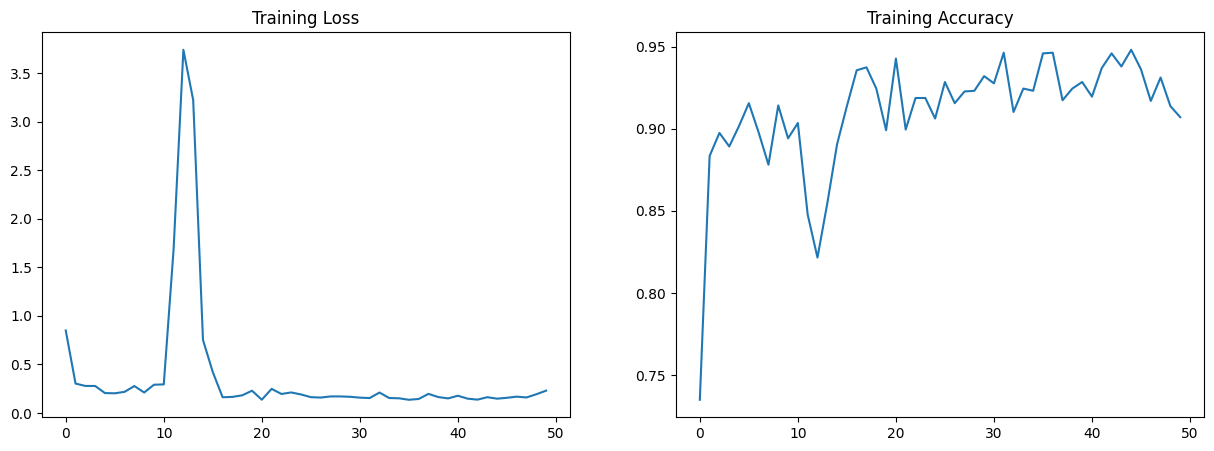

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
ax1.plot(range(0,epoches),training_loss)
ax1.set_title("Training Loss")
ax2.plot(range(0,epoches),training_accuracy)
ax2.set_title("Training Accuracy")
plt.show()

In [20]:
batch_loss = 0
batch_accuracy = 0
test_num_batches  = len(test_dataloader)

for batch, (X, y) in enumerate(test_dataloader):
    resnet_model.eval()
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        logits = resnet_model(X)
        loss = loss_fn(logits, y)
        y_pred = torch.argmax(F.softmax(logits,dim = 1),dim = 1)
        batch_loss += loss.item()
        batch_accuracy += (accuracy_score(y.cpu(),y_pred.cpu()))

print(f"average test loss = {batch_loss/test_num_batches}")
print(f"average test loss = {batch_accuracy/test_num_batches}")

average test loss = 0.18487837000025642
average test loss = 0.9004629629629629
